Imports

In [224]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import glob
import cv2

import tensorflow as tf
from keras import backend as K

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [225]:
train_path = r"C:\Users\alexa\Downloads\stage1_train"
test_path =  r"C:\Users\alexa\Downloads\stage1_test"
train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)

Create emmpty tensors for future images 

In [226]:
X_train = np.zeros((len(train_dir), 256, 256, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_dir), 256, 256, 1), dtype=bool)

X_test = np.zeros((len(test_dir), 256, 256, 3), dtype=np.uint8)

masks contains several images with different parts of the masks. We need to merge all the masks into one image using np.maximum. Further, just as with the original image, write to the pre-created tensor Y

We will compress all images to a size of 256x256x3, however, we will set the size of mask images to 256x256x1, since it makes no sense for us to store them in rgb format

In [227]:
%%time
for i, name in enumerate(train_dir):
    path = train_path + "\\" +name
    print(os.path.normpath(path+'/images/'+ name +'.png'))
    img_real = cv2.imread(os.path.normpath(path+'/images/'+ name +'.png'))
    img_real = cv2.resize(img_real,(256,256))
    X_train[i] = img_real
    
    img_segment_full = np.zeros((256, 256 , 1), dtype=bool)
    segment_path = path+'/masks/'
    for name in os.listdir(segment_path):
        img_segment = cv2.imread(segment_path + name, 0)
        img_segment = cv2.resize(img_segment, (256, 256))
        img_segment = np.expand_dims(img_segment, axis=-1)
        img_segment_full = np.maximum(img_segment_full, img_segment)
    
    Y_train[i] = img_segment_full

C:\Users\alexa\Downloads\stage1_train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\images\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png
C:\Users\alexa\Downloads\stage1_train\003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1\images\003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png
C:\Users\alexa\Downloads\stage1_train\00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e\images\00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png
C:\Users\alexa\Downloads\stage1_train\0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed\images\0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.png
C:\Users\alexa\Downloads\stage1_train\01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf\images\01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.png
C:\Users\alexa\Downloads\stage1_train\0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21\im

In [228]:
for i, name in enumerate(test_dir):
    path = test_path + '\\'+name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real, (256,256))
    X_test[i] = img_real

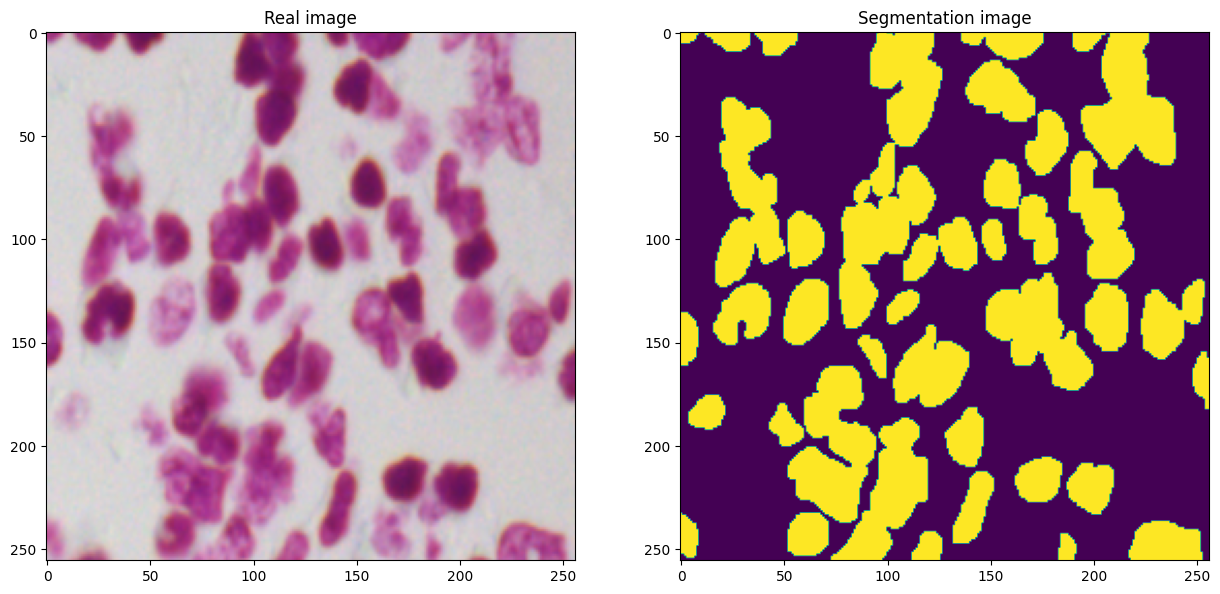

In [229]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(X_train[2])
plt.title('Real image')
plt.subplot(122)
plt.imshow(Y_train[2, :, :, 0])
plt.title('Segmentation image');

In [230]:
aug_gen_args = dict(shear_range = 0.2,
                    zoom_range = 0.2,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect'
                   )

X_train_gen = ImageDataGenerator(**aug_gen_args)
y_train_gen = ImageDataGenerator(**aug_gen_args)
X_val_gen = ImageDataGenerator()
y_val_gen = ImageDataGenerator()

To begin with, let's demonstrate on one image what augmentation looks like.

It is important to set the seed and shuffle=False in order for the original augmented images to match the segmented augmented images.

In [231]:
aug_image_real = X_train[5].reshape((1,)+X_train[1].shape)
aug_image_seg = Y_train[5].reshape((1,)+Y_train[1].shape)

In [232]:
aug_image_real_check = X_train_gen.flow(aug_image_real, batch_size=1, seed=17, shuffle=False)
aug_image_seg_check = y_train_gen.flow(aug_image_seg, batch_size=1, seed=17, shuffle=False)

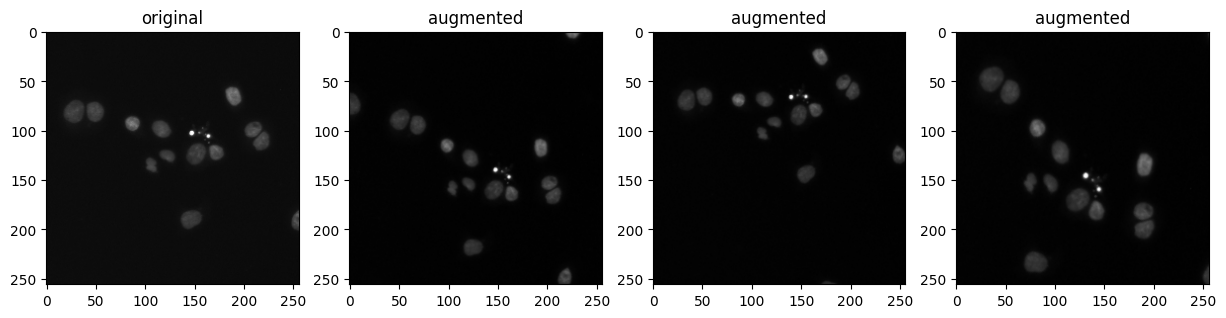

In [233]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(X_train[5])
plt.title("original")
i=2
for batch in aug_image_real_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

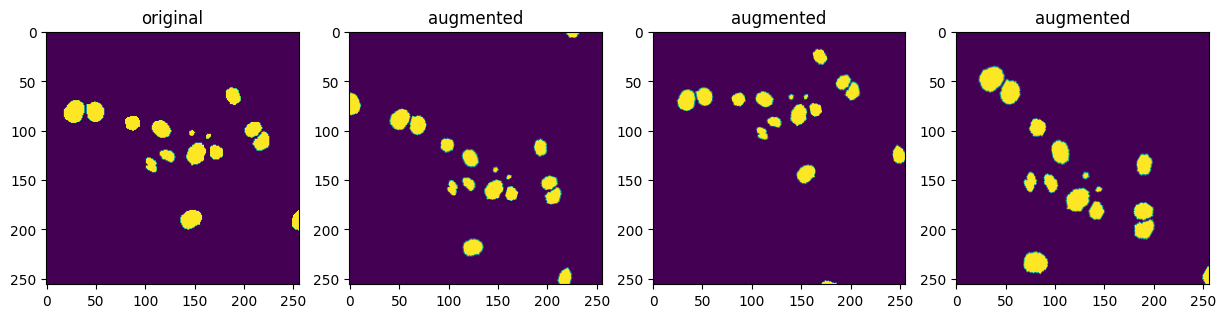

In [234]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(Y_train[5,:,:,0])
plt.title("original")
i=2
for batch in aug_image_seg_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

Let's split X_train into 2 parts: train and val. For val of the selection, select 0.1 data size

Next, apply the augmentation generators to the train data; no augmentation will be performed for the val data

Since we need to do augmentation for original images and segmented images, then we need to combine the generators into one using the zip()

In [235]:
train, val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=17)

In [236]:
X_train_gen.fit(train, augment=True, seed=17)
y_train_gen.fit(y_train, augment=True, seed=17)
X_val_gen.fit(val, seed=17)
y_val_gen.fit(y_val, seed=17)

X_train_generator = X_train_gen.flow(train, batch_size=16, seed=17, shuffle=False)
y_train_generator = y_train_gen.flow(y_train, batch_size=16, seed=17, shuffle=False)
X_val_generator = X_val_gen.flow(val, batch_size=16, seed=17, shuffle=False)
y_val_generator = y_val_gen.flow(y_val, batch_size=16, seed=17, shuffle=False)

train_generator = zip(X_train_generator, y_train_generator)
val_generator = zip(X_val_generator, y_val_generator)

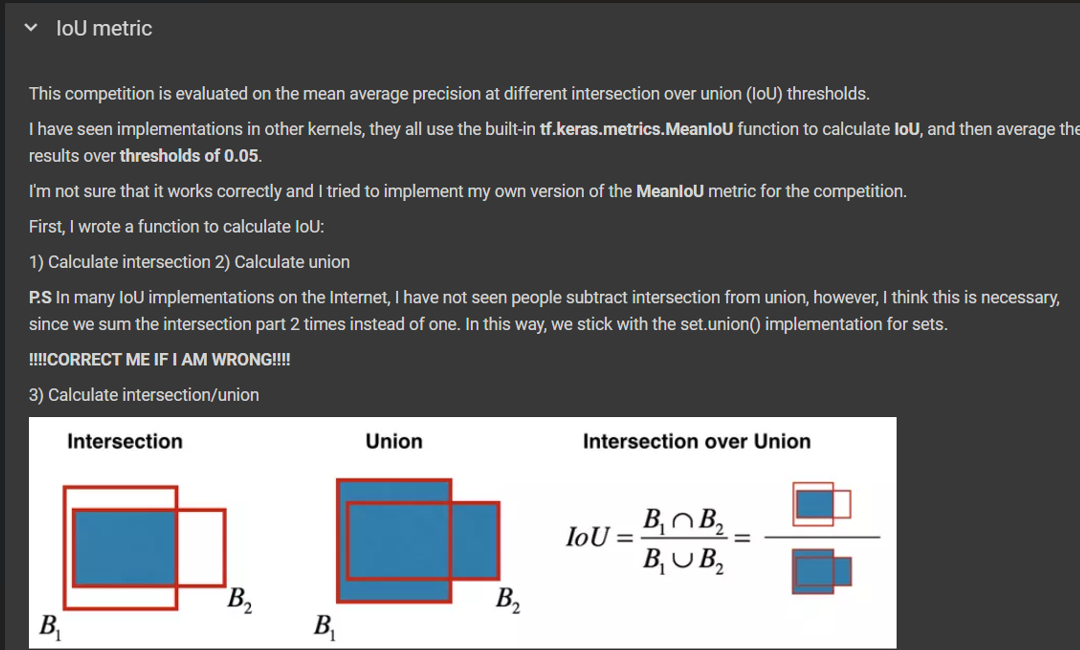


In [237]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

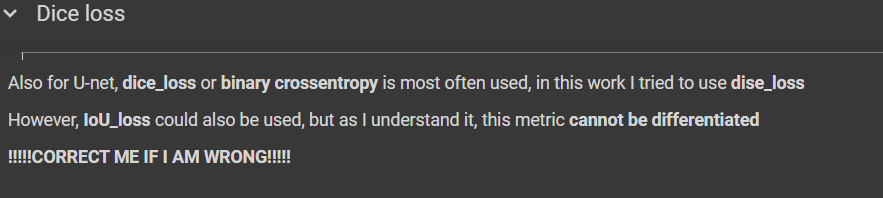

In [238]:
def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + 1) / (union + 1), axis=0)
    return 1. - dice

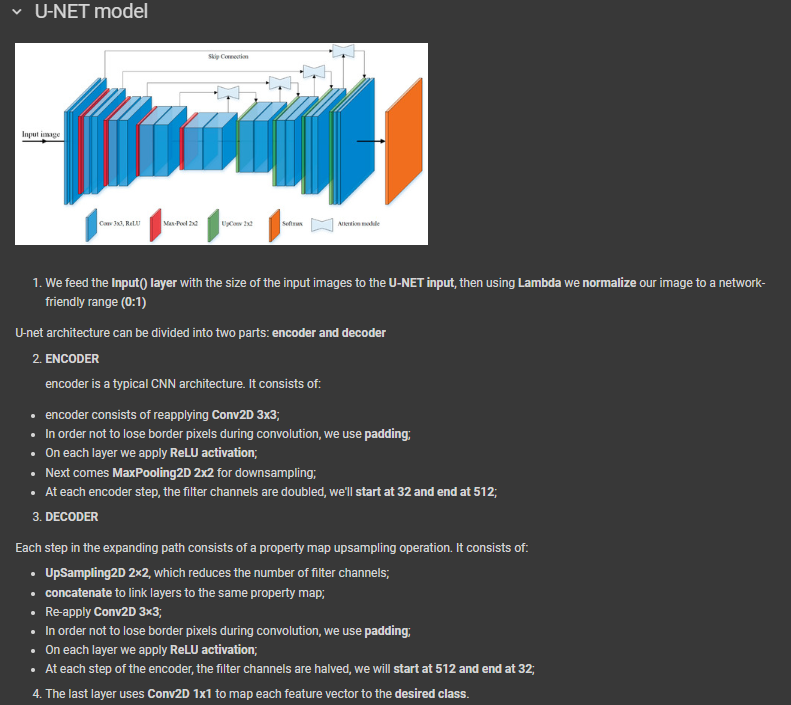

In [243]:
inputs = Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = UpSampling2D(size=(2,2))(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = UpSampling2D(size=(2,2))(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = UpSampling2D(size=(2,2))(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = UpSampling2D(size=(2,2))(conv8)
up9 = concatenate([up9, conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = models.Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss=dice_loss, metrics=[mean_iou])

In [244]:
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_400 (Conv2D) │ (None, 256, 256,  │        896 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_401 (Conv2D) │ (None, 256, 256,  │      9,248 │ conv2d_400[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_80    │ (None, 128, 128,  │          0 │ conv2d_401[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_402 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_80… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_403 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_402[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_81    │ (None, 64, 64,    │          0 │ conv2d_403[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_404 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_81… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_405 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_404[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_82    │ (None, 32, 32,    │          0 │ conv2d_405[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_406 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_82… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_407 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_406[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_83    │ (None, 16, 16,    │          0 │ conv2d_407[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_408 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_83… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_409 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_408[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_410 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_409[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_80    │ (None, 32, 32,    │          0 │ conv2d_410[0][0]

 Total params: 10,206,465 (38.93 MB)

 Trainable params: 10,206,465 (38.93 MB)

 Non-trainable params: 0 (0.00 B)

Training section
Set the train/val epoch size as len(train/val)/bath_size

Let's set epochs=25, I think this is enough to get good results

P.S. I won't use callbacks as a model with such a small amount of data and 25 epochs will learn quickly.

In [245]:
def iou(y_true, y_pred):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true, axis=[1,2,3]) + tf.keras.backend.sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.keras.backend.mean((intersection + 1) / (union + 1), axis=0)
    print(iou)
    return iou

def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return tf.keras.backend.mean(tf.keras.backend.stack(results), axis=0)

def dice_loss(y_true, y_pred):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true, axis=[1,2,3]) + tf.keras.backend.sum(y_pred, axis=[1,2,3])
    dice = tf.keras.backend.mean((2. * intersection + 1) / (union + 1), axis=0)
    return 1. - dice

def generator_wrapper(generator):
    while True:
        x, y = next(generator)
        yield x, y

history = model.fit(generator_wrapper(train_generator),
                    steps_per_epoch=int(len(train)/8),
                    validation_data=generator_wrapper(val_generator),
                    validation_steps=int(len(val)/8),
                    epochs=25
                   )

Epoch 1/25


C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_720']. Received: the structure of inputs=*
  warnings.warn(


Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)
Tensor("Mean_4:0", shape=(), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)
Tensor("Mean_6:0", shape=(), dtype=float32)
Tensor("Mean_7:0", shape=(), dtype=float32)
Tensor("Mean_8:0", shape=(), dtype=float32)
Tensor("Mean_9:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)
Tensor("Mean_4:0", shape=(), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)
Tensor("Mean_6:0", shape=(), dtype=float32)
Tensor("Mean_7:0", shape=(), dtype=float32)
Tensor("Mean_8:0", shape=(), dtype=float32)
Tensor("Mean_9:0", shape=(), dtype=float32)
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.7056 - mean_iou: 0.3025Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mea

KeyboardInterrupt: 

In [219]:
# # Convert boolean masks to float32
# y_train_float = y_train.astype(np.float32)
# y_val_float = y_val.astype(np.float32)

# # Supposons que train et val sont vos données d'origine
# train_dataset = tf.data.Dataset.from_tensor_slices((train, y_train_float)).batch(2)
# val_dataset = tf.data.Dataset.from_tensor_slices((val, y_val_float)).batch(2)

# def iou(y_true, y_pred):
#     intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
#     union = tf.keras.backend.sum(y_true, axis=[1,2,3]) + tf.keras.backend.sum(y_pred, axis=[1,2,3]) - intersection
#     iou = tf.keras.backend.mean((intersection + 1) / (union + 1), axis=0)
#     return iou

# def mean_iou(y_true, y_pred):
#     results = []   
#     for t in np.arange(0.5, 1, 0.05):
#         t_y_pred = tf.cast((y_pred > t), tf.float32)
#         pred = iou(y_true, t_y_pred)
#         results.append(pred)
        
#     return tf.keras.backend.mean(tf.keras.backend.stack(results), axis=0)

# def dice_loss(y_true, y_pred):
#     intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
#     union = tf.keras.backend.sum(y_true, axis=[1,2,3]) + tf.keras.backend.sum(y_pred, axis=[1,2,3])
#     dice = tf.keras.backend.mean((2. * intersection + 1) / (union + 1), axis=0)
#     return 1. - dice

# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=25
# )

Epoch 1/25


C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_612']. Received: the structure of inputs=*
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.9988 - mean_iou: 0.0038 - val_loss: 0.9996 - val_mean_iou: 2.1685e-04
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.9986 - mean_iou: 7.9629e-04 - val_loss: 0.9996 - val_mean_iou: 2.1596e-04
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.9986 - mean_iou: 7.9541e-04 - val_loss: 0.9996 - val_mean_iou: 2.1633e-04
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.9986 - mean_iou: 8.0410e-04 - val_loss: 0.9996 - val_mean_iou: 2.1723e-04
Epoch 5/25


KeyboardInterrupt: 

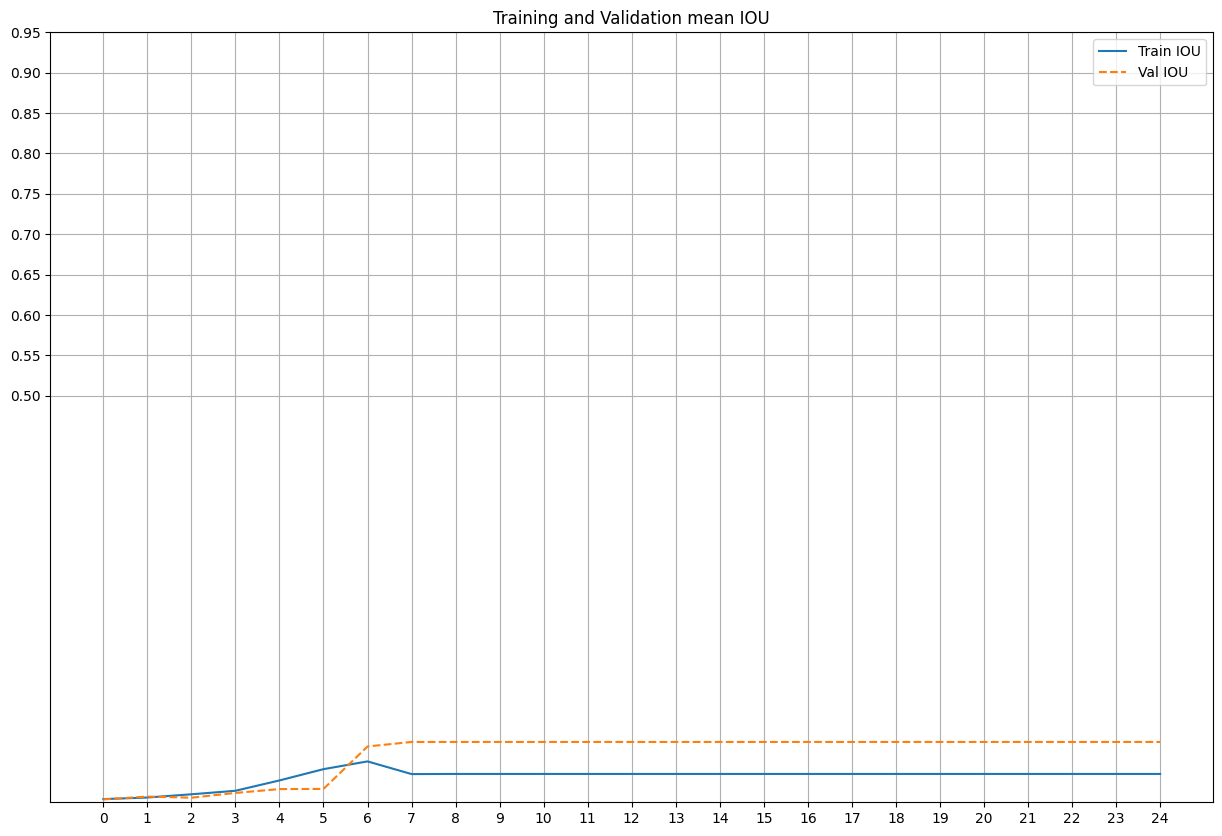

In [259]:
loss = history.history['mean_iou']
val_loss = history.history['val_mean_iou']
plt.figure(figsize=(15,10))
plt.plot(loss, label='Train IOU')
plt.plot(val_loss,'--', label='Val IOU')
plt.title('Training and Validation mean IOU')
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(np.arange(0, 25))
plt.grid()
plt.legend();

Result

In [255]:
train_pred = model.predict(train, verbose = 1)
val_pred = model.predict(val, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


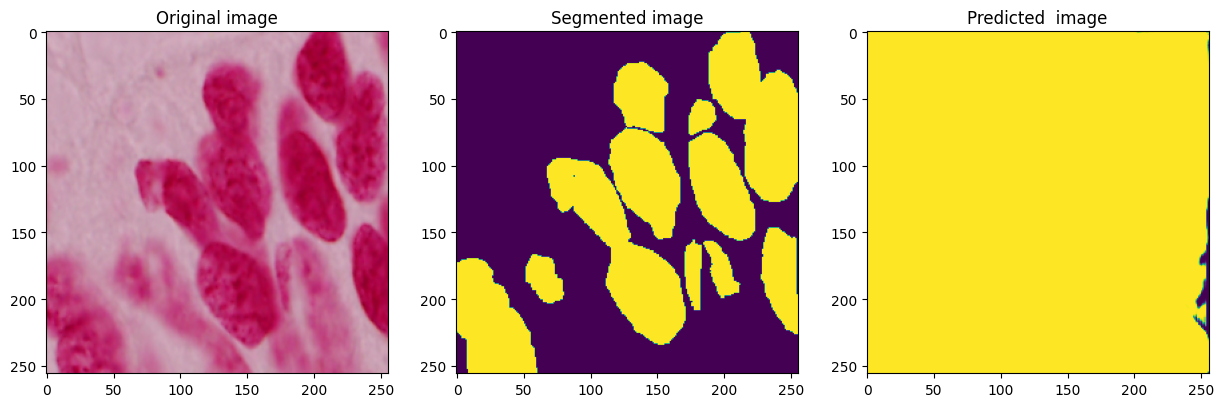

In [256]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(train[1])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_train[1]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(train_pred[1]))
plt.title('Predicted  image');

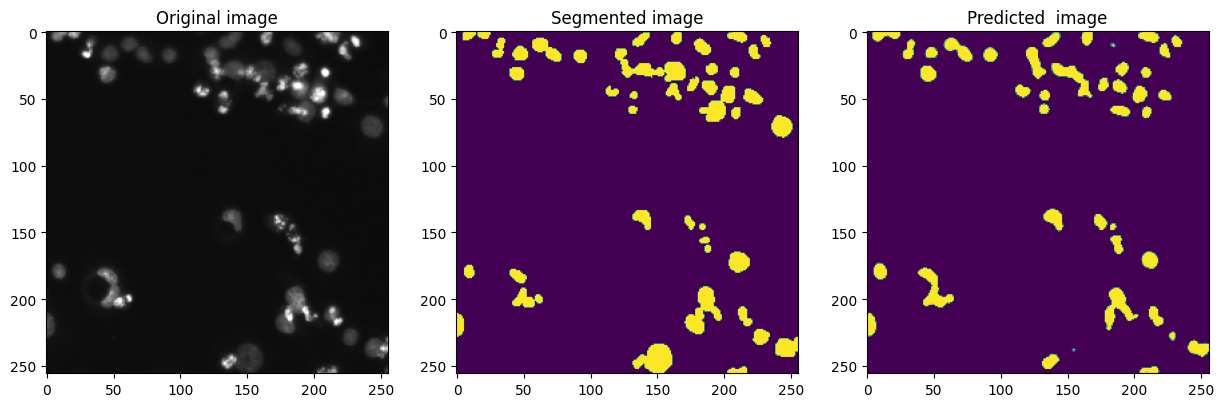

In [258]:
index = 4 # Ensure the index is within the bounds of the val array
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(val[index])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_val[index]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(val_pred[index]))
plt.title('Predicted  image');